<a href="https://colab.research.google.com/github/yuluj/credit-card-default-prediction/blob/main/credit_card_default_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to the Google Colab notebook: https://colab.research.google.com/drive/1Vm-1lHQLAQmquy9QNglM2xnnXb8PKEIL?usp=sharing

In this homework fit and select a classifier to predict credit card default using `default_of_credit_card_clients` dataset from BlackBoard course site. The data description is available at : https://www.kaggle.com/datasets/jishnukoliyadan/taiwan-default-credit-card-clients

1. Explore (5+5+10=20 points)
  1. load the dataset. Use only the columns "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", and "AGE" among predictors. The target is "default payment next month". 
  1. identify the categorical features (with brief explanation), and 
  1. produce the pairwise scatter plot. 
1. Prepare a pipeline to (30 points)
  1. standardize the numeric attributes
  1. expand the categorical attributes to columns of 0/1 variables
  1. fit a `RandomForestClassifier` classifier
1. Search over the `max_depth` and `min_samples_leaf` parameters to find the best model per balanced accuracy metric. Use at least three different search strategies and discuss any differences you see in the results. (20 points)
1. Let's assume that the cost of missing a default (i.e., predicting non-default for a customer who ended up defaulting) is 10 times the cost of flagging a non-defaulter as defaulter. Let's further assume that the cost of correct predictions are 0. Use any one of the search strategies considered in the previous question to find the `RandomForestClassifier` that minimizes the cost. (20 points)
1. Collaboration statement: Who did you discuss while answering this homework (whether to get or to provide help)? What questions/topics did you discuss? (10 points)

Note: No penalty for either side. While getting help in figuring out how to solve is OK, all answers should be produced by you. 


## 1. Explore 



### 1. load the dataset. Set predictors and target.

In [ ]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
plt.style.use('seaborn-white')

In [ ]:
# load dataset
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
data_folder = '/content/drive/MyDrive/BA810/'
credit_card = pd.read_csv(data_folder+'default_of_credit_card_clients.csv')

Mounted at /content/drive


In [ ]:
# overview of the dataset
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [ ]:
# rename the column to call easier
credit_card.rename(columns = {'default payment next month':'default'}, inplace = True)

In [ ]:
# only keep selected columns
credit_card = credit_card[["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "default"]]

In [ ]:
# set the target
credit_card_predictors = credit_card.drop("default", axis = 1) #predictors
credit_card_target = credit_card["default"].copy() #target

In [ ]:
# change the categorical type
credit_card.SEX=credit_card.SEX.astype('category')
credit_card.EDUCATION=credit_card.EDUCATION.astype('category')
credit_card.MARRIAGE=credit_card.MARRIAGE.astype('category')
print(credit_card.dtypes)

LIMIT_BAL       int64
SEX          category
EDUCATION    category
MARRIAGE     category
AGE             int64
default         int64
dtype: object


In [ ]:
# preview of the dataset
credit_card.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default
0,20000,2,2,1,24,1
1,120000,2,2,2,26,1
2,90000,2,2,2,34,0
3,50000,2,2,1,37,0
4,50000,1,2,1,57,0


### 2. identify the categorical features (with brief explanation)

Categorical features:
1. SEX
<br>This is divided to two categories: 1 = male; 2 = female. It means the whole customer set can be divided by their gender.
2. EDUCATION
<br>There are four categories in this feature: 1 = graduate school; 2 = university; 3 = high school; 4 = others. This implies that we could differentiate customer by thier educational background. It makes education as a categorical variable.
3. MARRIAGE
<br>Also, this is divided to three marital stauts: 1 = married; 2 = single; 3 = others. We could use this to discover the relationship with marital status of customers and the outcome variable.
4. default payment next month (now named 'default')
<br>This feature being the outcome variable is a boolean. 0 being no, and 1 being yes. And we can match all the customers into this two results in this dataset.

### 3. produce the pairwise scatter plot

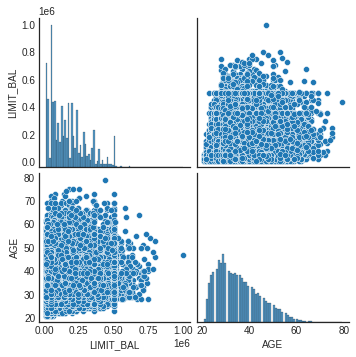

In [ ]:
sns.pairplot(credit_card[["LIMIT_BAL", "AGE"]])

## 2. Prepare a pipeline to

### 1. standardize the numeric attributes

In [ ]:
# standardizing the numeric columns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import set_config

set_config(display='diagram')

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

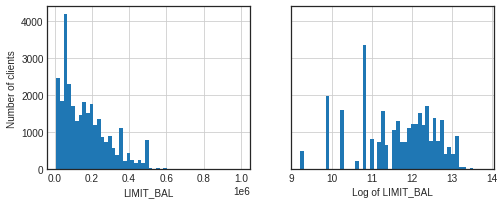

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
credit_card["LIMIT_BAL"].hist(ax=axs[0], bins=50)
credit_card["LIMIT_BAL"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("LIMIT_BAL")
axs[1].set_xlabel("Log of LIMIT_BAL")
axs[0].set_ylabel("Number of clients")
plt.show()

### 2.  expand the categorical attributes to columns of 0/1 variables

In [ ]:
# expanding the categorical variables
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False, drop="first"))
    ])

### 3.  fit a RandomForestClassifier classifier

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC  

num_attribs = ["LIMIT_BAL", "AGE"]
cat_attribs = ["SEX", "EDUCATION", "MARRIAGE"]

# The following step patches SimpleImputer to produce feature names
SimpleImputer.get_feature_names_out = StandardScaler.get_feature_names_out

preprocess_pipeline = ColumnTransformer([ 
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

preprocess_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['LIMIT_BAL', 'AGE']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 ['SEX', 'EDUCATION', 'MARRIAGE'])])

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(credit_card, test_size = .25, random_state=0)

train_data.shape, test_data.shape

((22500, 6), (7500, 6))

In [ ]:
df_X = train_data.drop("default", axis=1)
df_y = train_data["default"]
print(df_X.head())  # to check that "default" isn't included

X_train = preprocess_pipeline.fit_transform(df_X)
y_train = df_y.values
preprocess_pipeline.get_feature_names_out() # check the column names produced by the pipeline

       LIMIT_BAL SEX EDUCATION MARRIAGE  AGE
12880     130000   2         1        2   27
14868     130000   2         3        1   53
14280     140000   1         3        1   38
5318      270000   2         2        1   33
15421     220000   2         2        1   53


array(['num__LIMIT_BAL', 'num__AGE', 'cat__SEX_2', 'cat__EDUCATION_1',
       'cat__EDUCATION_2', 'cat__EDUCATION_3', 'cat__EDUCATION_4',
       'cat__EDUCATION_5', 'cat__EDUCATION_6', 'cat__MARRIAGE_1',
       'cat__MARRIAGE_2', 'cat__MARRIAGE_3'], dtype=object)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
full_pipeline = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('random_forest',RandomForestClassifier(n_estimators=102, random_state=42)),
])
full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LIMIT_BAL', 'AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE'])])),
                ('random_forest',
                 RandomForestClassifier(n_estimators=102, random_state=42))])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=102, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=102, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

X_test = preprocess_pipeline.transform(test_data)
y_test = test_data["default"]
y_pred = forest_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7353333333333333

In [ ]:
balanced_accuracy_score(y_test, y_pred).round(4)

0.5279

## 3. Search over parameters

Search over the max_depth and min_samples_leaf parameters to find the best model per balanced accuracy metric. Use at least three different search strategies and discuss any differences you see in the results.

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [ 
    {'random_forest__max_depth': [2, 6, 8, 10], 
    'random_forest__min_samples_leaf': [2, 6, 8, 10]}
    ]
print('The parameter grid : ')
print(param_grid)

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='balanced_accuracy')
grid_search.fit(df_X, df_y)

grid_search.best_estimator_
gs_res = pd.DataFrame(grid_search.cv_results_)
gs_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
gs_res.filter(regex = '(iter|^param_|mean_test_score|std_test_score|n_resources)', axis=1).head()

The parameter grid : 
[{'random_forest__max_depth': [2, 6, 8, 10], 'random_forest__min_samples_leaf': [2, 6, 8, 10]}]


,param_random_forest__max_depth,param_random_forest__min_samples_leaf,mean_test_score,std_test_score
12,10,2,0.502324,0.000281
14,10,8,0.500642,0.001155
13,10,6,0.500313,0.000665
10,8,8,0.500043,0.000060
0,2,2,0.500000,0.000000


To understand that the hyperparameter combination of the best test score performance is not selected on random, we could subtract the mean test score by its standard deviation, and compare it with the second highest hyperparameter combination.

Here, the highest `mean_test_score` is 0.502324, and its `std_test_score` is 0.000281. Subtracting them could get 0.502043, which is still higher than the second highest `mean_test_score` of 0.500642. This means even if randomness is taken into account, the hyperparameter combination of the highest performance could still be performing well.

### Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

full_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("random_forest", RandomForestClassifier(n_estimators=102, random_state=42)),
])
param_distribs = [ 
    {'random_forest__max_depth': randint(2, 10), 
    'random_forest__min_samples_leaf': randint(2, 10)}    
    ]
random_search = RandomizedSearchCV(full_pipeline, param_distribs, n_iter=20, cv=3, 
                                 scoring='balanced_accuracy', random_state=42)
random_search.fit(df_X, df_y)
random_search.best_estimator_
rs_res = pd.DataFrame(random_search.cv_results_)
rs_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
rs_res.filter(regex = '(iter|^param_|mean_test_score|std_test_score|n_resources)', axis=1).head()

,param_random_forest__max_depth,param_random_forest__min_samples_leaf,mean_test_score,std_test_score
9,9,4,0.500299,0.000333
7,9,6,0.500271,0.000402
14,9,5,0.500142,0.000132
4,8,3,0.500085,0.000210
19,2,4,0.500000,0.000000


### Halving Random Search

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from scipy.stats import randint

param_distribs = [ 
    {'random_forest__max_depth': randint(2, 10), 
    'random_forest__min_samples_leaf': randint(2, 10)}  
    ]
halving_random_search = HalvingRandomSearchCV(full_pipeline, param_distribs, 
                                      n_candidates=20, cv=3, 
                                      min_resources='exhaust',
                                      scoring='balanced_accuracy', 
                                      random_state=42)

halving_random_search.fit(df_X, df_y)
halving_random_search.best_estimator_
halving_random_cv_res = pd.DataFrame(halving_random_search.cv_results_)
halving_random_cv_res.sort_values(by=['mean_test_score'], ascending=False, inplace=True)
halving_random_cv_res.filter(regex = '(^param_|mean_test_score|std_test_score|n_resources)', axis=1).head()

,n_resources,param_random_forest__max_depth,param_random_forest__min_samples_leaf,mean_test_score,std_test_score
13,2500,7,3,0.505630,0.003329
4,2500,8,3,0.505365,0.003413
9,2500,9,4,0.505234,0.002634
3,2500,6,6,0.503366,0.003025
15,2500,6,2,0.502742,0.003001


As discussed in Grid Search, sometimes we need to examine if the best performing parameter combination is sustainable. By subtracting the highest `mean_test_score` with its `std_test_score` of the Halving Random Search, it appears to be **lower than**  the second highest `mean_test_score`. 



---



---



In Grid Search, we select 2, 6, 8, 10 for candidates of `param_random_forest_max_depth` and `param_random_forest_min_samples_leaf`. In Random Search and the Halving version, we set these two in the range of 2 to 10. Within this range, the search will select the best-performed random combination of hyperparameters.



The test result turns out that the Halving Random Search found the parameter combination with the highest `mean_test_score`. The reason being that is Random Search performs well with the low dimensional data as we only limit to 5 predictors in this case. And **Halving** Random Search could filter out the worst performing data by training on a small subset. However, the standard deviation for the test score is quite high compared with that of Grid Search. This is because Grid Search aims to find the absolute best way to tune the hyperparameters.


Overall saying, the Random Search is more efficient, while the Grid Search ensures the best hyperparameter combination out of all the available choices.


Source: [Comparing Grid and Randomized Search Methods in Python](https://betterprogramming.pub/comparing-grid-and-randomized-search-methods-in-python-cd9fe9c3572d?gi=65395c8fb832
)


## 4. Find the RandomForestClassifier that minimizes the cost

Let's assume that the cost of missing a default (i.e., predicting non-default for a customer who ended up defaulting) is 10 times the cost of flagging a non-defaulter as defaulter. Let's further assume that the cost of correct predictions are 0. Use any one of the search strategies considered in the previous question to find the RandomForestClassifier that minimizes the cost. 

In this question, we use Grid Search to find the RandomForestClassifer that minimizes the cost.

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10, scoring='balanced_accuracy')
forest_scores.mean().round(3)

0.523

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix
def default_cost(y_true, y_pred): 
  cm = confusion_matrix(y_true, y_pred)
  return cm[1,0] * 10 + cm[0,1] * 1

cost_scorer = make_scorer(default_cost, greater_is_better=False)

forest_costs = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring=cost_scorer)
forest_costs.mean()

full_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("random_forest", RandomForestClassifier(n_estimators=102, random_state=42)),
])
param_grid = [ 
    {'random_forest__max_depth': [2, 5, 10], 
    'random_forest__min_samples_leaf': [2, 5, 10]}
    ]


grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring=cost_scorer)
grid_search.fit(df_X, df_y)

cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.filter(regex = '(^param_|mean_test_score|std_test_score|n_resources)', axis=1).head()

,param_random_forest__max_depth,param_random_forest__min_samples_leaf,mean_test_score,std_test_score
6,10,2,-16582.000000,9.416298
7,10,5,-16636.333333,4.921608
8,10,10,-16663.333333,17.152907
0,2,2,-16680.000000,0.000000
1,2,5,-16680.000000,0.000000


## Collaboration Statement

Who did you discuss while answering this homework (whether to get or to provide help)? What questions/topics did you discuss? (10 points)

I went to Hazel's office hour to discuss if we should include the "cost" output in Section 4. Also we discussed if I should include the output variable "default" in Section 1.2.